### NAME : S.Sanjith

### ID NO : 190562G

### COURSE CODE : EN2550


In [27]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.linalg import null_space

def imshowBGR(img,ax=plt):
    plt.figure()
    ax.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    
im_dir = 'E:/Semester 4/EN2550_FundamentalsOfImageProcessing/Fun-Time/Exercises/images/templeSparseRing/'

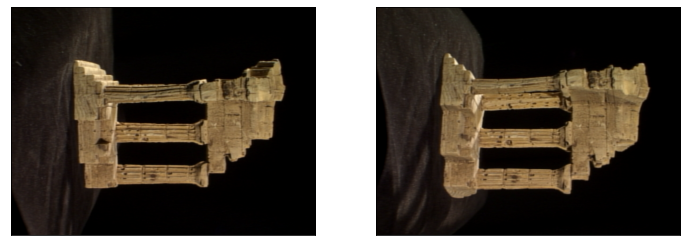

In [22]:
f = open(r'./templeSparseRing/templeSR_par.txt')
assert f is not None

n=int(f.readline())

# Reading the information on the first image

l = f.readline().split()
im1_fn = l[0]
K1=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1=np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image
l =( f.readline()).split()
im2_fn = l[0]
K2=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2=np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two images and show
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = cv.imread(im_dir+ im1_fn,cv.IMREAD_COLOR)
im2 = cv.imread(im_dir+im2_fn,cv.IMREAD_COLOR)

assert im1 is not None
assert im2 is not None

ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))

for i in range (2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])


plt.show()

# Compute P1 and P2
P1 = K1 @ np.hstack((R1,t1))   # P= K*[R|t]
P2 = K2 @ np.hstack((R2,t2))   


In [24]:
# Computing Fundamental Matrix
def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])


c = null_space(P1)
c = c*np.sign(c[0, 0])

e2 = P2@c
e2x=skew(e2)

F= e2x @ P2 @ np.linalg.pinv(P1)
F

array([[-2.87071497e-04, -3.96261289e-02,  2.94221686e+02],
       [-3.55039713e-02,  1.65329260e-04,  1.78860854e+01],
       [-2.76702814e+02,  2.12942175e+01, -9.06669374e+03]])

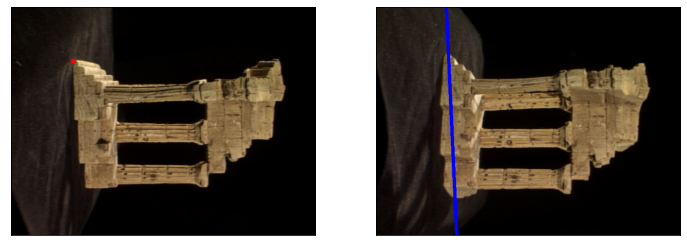

In [25]:
# Ploting the point X
x = np.array([130, 115, 1])
cv.circle(im1, (x[0], x[1]), 5, (0, 0, 255), -1)


# Plotting epipolar line through X
l2 = F@x.T
p1 = np.array([0,(l2[0]*0+l2[2])/l2[1]]).astype(int)
p2=np.array([500,(l2[0]*500+l2[2]*1)/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])


plt.show()


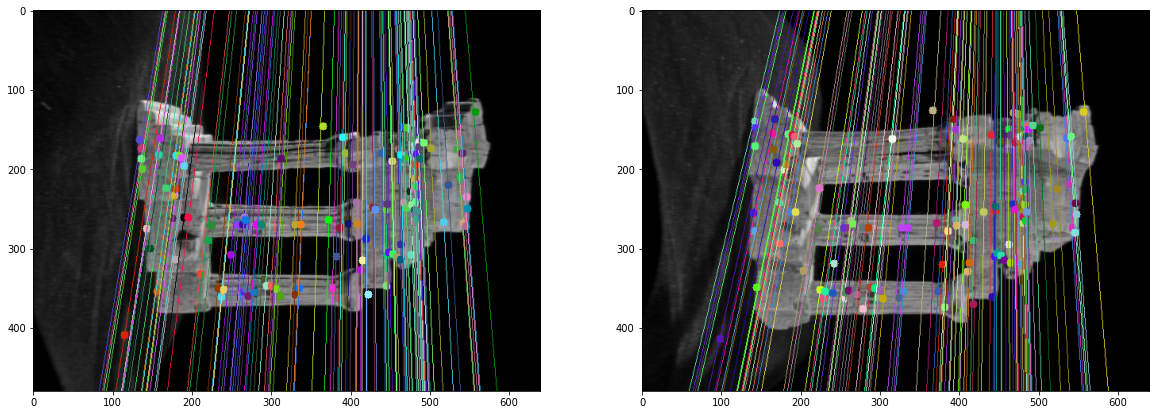

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [28]:
# q4

im1 = cv.imread(im_dir+im1_fn,cv.IMREAD_GRAYSCALE)
im2 = cv.imread(im_dir+im2_fn,cv.IMREAD_GRAYSCALE)
sift = cv.SIFT_create()

kp1, dp1 = sift.detectAndCompute(im1,None)
kp2, dp2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams,searchParams)
matches = flann.knnMatch(dp1,dp2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(im1,im2,lines,pts1,pts2):
    r,c = im1.shape
    im1 = cv.cvtColor(im1,cv.COLOR_GRAY2BGR)
    im2 = cv.cvtColor(im2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        im1 = cv.line(im1, (x0,y0), (x1,y1), color,1)
        im1 = cv.circle(im1,tuple(pt1),5,color,-1)
        im2 = cv.circle(im2,tuple(pt2),5,color,-1)
    return im1,im2

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
im5,im6 = drawlines(im1,im2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
im3,im4 = drawlines(im2,im1,lines2,pts2,pts1)

fix,ax=plt.subplots(1,2,figsize=(20,20))
imshowBGR(im5,ax[0])
imshowBGR(im3,ax[1])